In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import scikitplot as skplt

import pickle

In [2]:
def test_languages(X_test, true_values, predictions):
    """"
    Takes in data and model predictions. Prints results to visualize performance
    """
    
    true_values = np.array(true_values)
    
    for i, sentence in enumerate(X_test):
        prediction = float(predictions[i])
        true_value = float(true_values[i])
        print("Prediction: " + str(labels[prediction]))
        print("Actual Language: " + str(labels[true_value]))
        print("Input Sentence: ")
        print(sentence)
        print('\n')

In [3]:
df = pd.read_csv('lang_data_processed.csv')

In [4]:
df.head()

,text,language
0,things that go bump in the night,English
1,keep it under your hat,English
2,die laaitie se hakskene word rooi,Afrikaans
3,earmark,English
4,bums on seats,English


In [5]:
# create binary labels
df['labels'] = df.language.map({'English': 0, 'Afrikaans': 1, 'Nederlands': 2})

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.labels, test_size = 0.33, random_state = 42)

In [7]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df.labels.value_counts()

0    1237
1     374
2      37
Name: labels, dtype: int64

In [8]:
class0 = train_df[train_df.labels == 0]
class1 = train_df[train_df.labels == 1]
class2 = train_df[train_df.labels == 2]
max = train_df.labels.value_counts().max()

if len(train_df[train_df.labels == 0]) == max:
    majority = class0
    minority1 = class1
    minority2 = class2
elif len(train_df[train_df.labels == 1]) == max:
    minority1 = class0
    majority = class1
    minority2 = class2
else:
    minority1 = class0
    minority2 = class1
    majority = class2

In [9]:
new_minority1 = resample(minority1, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

new_minority2 = resample(minority2, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority1])
train_df = pd.concat([train_df, new_minority2])
train_df = shuffle(train_df, random_state=42)

train_df.labels.value_counts()

1    1237
2    1237
0    1237
Name: labels, dtype: int64

In [10]:
y_train = train_df.labels
X_train= train_df.text

In [11]:
parameters = {   
    'clf__alpha': [1, 1e-1, 1e-2, 1e-3, 0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
}
    
def perform_grid_search(X_data, y_data):
    tfidf_vect = TfidfVectorizer(analyzer='char')
    model = MultinomialNB()
    text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])
    
    clf = GridSearchCV(text_clf, parameters, cv=4, scoring=None, n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['clf__alpha'], clf.best_params_['tfidf__ngram_range'], clf.best_params_['tfidf__use_idf'], \
        clf.best_params_['tfidf__norm']


In [12]:
# extract parameters
clf__alpha, tfidf__ngram_range , tfidf__use_idf, tfidf__norm= perform_grid_search(X_train, y_train)
print(clf__alpha, tfidf__ngram_range , tfidf__use_idf, tfidf__norm)

[0.78253508 0.7997846  0.77714425 0.80274883 0.9679328  0.94233374
 0.97736342 0.95931124 0.96847043 0.96011827 0.98679434 0.97440035
 0.97601557 0.96604615 0.98140495 0.97763282 0.77768449 0.80032252
 0.77633664 0.80301794 0.98032737 0.96982119 0.98248341 0.97655756
 0.99029795 0.98302308 0.99380097 0.99299278 0.98194433 0.98194433
 0.98248283 0.98517854 0.77795418 0.80032107 0.77660632 0.80247798
 0.98194433 0.97925182 0.98248341 0.98086849 0.99380068 0.99353187
 0.99380097 0.99460974 0.98356129 0.98598702 0.98248283 0.98625671
 0.77795418 0.80032107 0.77660632 0.80247798 0.98194433 0.98113817
 0.9824837  0.98113788 0.99326218 0.99407095 0.9927231  0.99460974
 0.98329189 0.9867955  0.98194404 0.98625671 0.77795418 0.79843529
 0.77660632 0.80247798 0.98113643 0.98059967 0.98167551 0.98032998
 0.99137553 0.99164551 0.99137553 0.99191491 0.98194491 0.98544852
 0.98113585 0.98490972]
0.01 (1, 3) False l2


In [13]:
tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=tfidf__ngram_range, use_idf=tfidf__use_idf, norm=tfidf__norm)
model = MultinomialNB(alpha=clf__alpha)
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])

In [14]:
text_clf.fit(X_train, y_train)
predictions = text_clf.predict(X_test)
accuracy_score(y_test,predictions)

0.9630541871921182

In [15]:
scores = cross_val_score(text_clf, df.text, df.labels, cv=5)
print(scores.mean())

0.9792682926829268


In [16]:
print(classification_report(y_test, predictions, target_names=df.language.unique()))

              precision    recall  f1-score   support

     English       0.99      0.97      0.98       602
   Afrikaans       0.89      0.99      0.94       188
  Nederlands       0.85      0.50      0.63        22

    accuracy                           0.96       812
   macro avg       0.91      0.82      0.85       812
weighted avg       0.96      0.96      0.96       812



Confusion matrix, without normalization
[[584  16   2]
 [  1 187   0]
 [  3   8  11]]
Normalized confusion matrix
[[0.97009967 0.02657807 0.00332226]
 [0.00531915 0.99468085 0.        ]
 [0.13636364 0.36363636 0.5       ]]


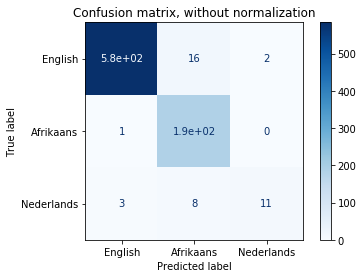

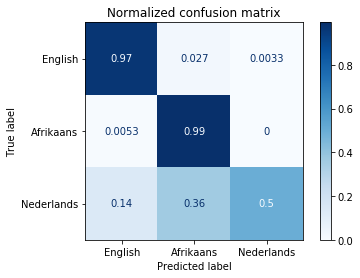

In [17]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
class_names = ['English', 'Afrikaans', 'Nederlands']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(text_clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    plt.grid(False)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.grid(False)
plt.show()

In [18]:
labels = {0.0:'English', 1.0:'Afrikaans', 2.0: 'Nederlands'}
test_languages(X_test, y_test, predictions)

Prediction: English
Actual Language: English
Input Sentence: 
the chickens come home to roost


Prediction: English
Actual Language: English
Input Sentence: 
go off halfcocked


Prediction: English
Actual Language: English
Input Sentence: 
designer stubble


Prediction: English
Actual Language: English
Input Sentence: 
high five


Prediction: English
Actual Language: English
Input Sentence: 
bone idle


Prediction: English
Actual Language: English
Input Sentence: 
away with the fairies


Prediction: English
Actual Language: English
Input Sentence: 
going to hell in a handbasket


Prediction: English
Actual Language: English
Input Sentence: 
good riddance


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
hy maak of hy geld in die bank het


Prediction: English
Actual Language: English
Input Sentence: 
dock your pay


Prediction: English
Actual Language: English
Input Sentence: 
billy no mates


Prediction: English
Actual Language: English
Input Sentence: 
clean breast 



Prediction: Afrikaans
Actual Language: English
Input Sentence: 
pellmell


Prediction: English
Actual Language: English
Input Sentence: 
mother country


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
draai jou mantel na die wind


Prediction: English
Actual Language: English
Input Sentence: 
come on down


Prediction: English
Actual Language: English
Input Sentence: 
man who is his own lawyer has a fool for a client  a


Prediction: English
Actual Language: English
Input Sentence: 
anchors aweigh


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
liewers ‘n kort skande as ‘n lang verdriet


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
moet nooit ‘n apologie met ‘n verskoning bederf nie


Prediction: English
Actual Language: English
Input Sentence: 
pie in the sky


Prediction: English
Actual Language: English
Input Sentence: 
lackadaisical


Prediction: Afrikaans
Actual Language: Afrikaans
Input Sentence: 
sit die babatjie op 

In [19]:
from sklearn.metrics import roc_auc_score

y_prob = text_clf.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.993268 (macro),
0.995364 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.996431 (macro),
0.998446 (weighted by prevalence)


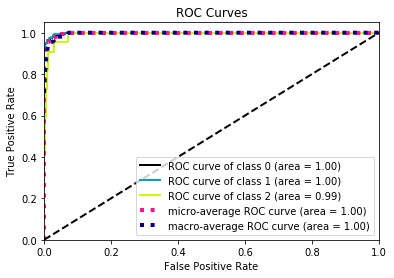

In [20]:
y_prob = text_clf.predict_proba(X_test)

plot = skplt.metrics.plot_roc(y_test, y_prob)
plt.title("ROC Curves");

In [21]:
train_df = pd.concat([df.labels, df.text], axis=1, join='inner')
train_df.labels.value_counts()

0    1839
1     562
2      59
Name: labels, dtype: int64

In [22]:
class0 = train_df[train_df.labels == 0]
class1 = train_df[train_df.labels == 1]
class2 = train_df[train_df.labels == 2]
max = train_df.labels.value_counts().max()

if len(train_df[train_df.labels == 0]) == max:
    majority = class0
    minority1 = class1
    minority2 = class2
elif len(train_df[train_df.labels == 1]) == max:
    minority1 = class0
    majority = class1
    minority2 = class2
else:
    minority1 = class0
    minority2 = class1
    majority = class2

In [23]:
new_minority1 = resample(minority1, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

new_minority2 = resample(minority2, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority1])
train_df = pd.concat([train_df, new_minority2])
train_df = shuffle(train_df, random_state=42)

train_df.labels.value_counts()

2    1839
1    1839
0    1839
Name: labels, dtype: int64

In [24]:
text_clf.fit(train_df.text, train_df.labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=False,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))],
         verbose=False)

In [25]:
pickle.dump(text_clf, open('language_classifier_gridsearch', 'wb'))